In [1]:
using Flux, Statistics
using Flux: crossentropy, throttle, logitcrossentropy
using Base.Iterators: repeated, partition, flatten
using DelimitedFiles
using LinearAlgebra
using RDatasets
using GLM
using BSON: @save, @load
using Random
using Base.Threads 
using Plots

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/jupyter-tegan/.julia/packages/CUDA/mVgLI/src/initialization.jl:42


In [2]:
#import Pkg; Pkg.add("BSON")

In [3]:
#import Pkg; Pkg.add("GLM")

In [4]:
#import Pkg; Pkg.add("RDatasets")

In [5]:
function getEdepGateBarA0(number, angle) #E02_W05_A000_bars_extracted.txt 
    folder = "/home/jupyter-tegan/dosimeter/gate_data/bars/"
    angle = lpad(angle,3, "0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end # 66x21 matrix

getEdepGateBarA0 (generic function with 1 method)

In [6]:
getEdepGateBarA0(50, 15) #before (99, 20)

8×8 Matrix{Int64}:
 2  23  261   96  122  104  34  1
 3  83  236  145  131  130  41  2
 3  70  295  161   91  128  46  1
 0  84  199  110   85  160  49  1
 1  70  133   86  116  162  96  2
 1  38  173  152  165  122  58  1
 1  22  125   98  151   89  54  1
 0  25   37   32   62   61  13  1

In [7]:
function getEdepGateBarA90(number, angle) #E02_W05_H05_A225_bars_extracted.txt 
    folder = "/home/jupyter-tegan/dosimeter/gate_data/bars/"
    angle90 = lpad(angle+90, 3, "0")
    fileName90 = filter(x->occursin(string("A", angle90), x), readdir(folder))[number]
    filePath90 = string(folder, fileName90)
    return return Int.(round.(reshape(readdlm(filePath90)[4:67,2], (8,8))))
end 

getEdepGateBarA90 (generic function with 1 method)

In [8]:
getEdepGateBarA90(10, 255) #before (4, 260)

8×8 Matrix{Int64}:
 2   48  240  200  182  151   45  2
 1   27  281  212  162  213   48  2
 2   38  169  230  231  186  116  2
 5   52  163  228  207  199  110  6
 1   75  194  264  136  124   58  3
 1  122  119  147  239  230  104  1
 1   51  109  145  176  172  130  1
 1   19   64   63   90   56   55  1

In [9]:
function getEdepGateGrid(number, angle)
    folder = "/home/jupyter-tegan/dosimeter/gate_data/cubes/"
    angle = lpad(angle, 3, "0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(readdlm(filePath)[4:515,2]))
end

getEdepGateGrid (generic function with 1 method)

In [10]:
getEdepGateGrid(4, 45) #before (1, 40)

512-element Vector{Int64}:
 0
 0
 1
 0
 0
 0
 0
 0
 0
 1
 0
 1
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [11]:
function getEdepOhioBarA0(number)
    folder = "/home/jupyter-tegan/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R...txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA0 (generic function with 1 method)

In [12]:
getEdepOhioBarA0(1)

8×8 Matrix{Int64}:
 38484  42128  52850  126117  208366  54216  42413  38391
 39382  44555  47446  118228  285328  61556  41870  39128
 36595  39956  55851  189571  294911  57231  42411  38908
 38021  43502  45917  122588  483994  71271  40778  39157
 40115  46611  55757  176140  345909  74524  42913  39929
 39228  38664  58439  162217  244550  68536  43572  39139
 37466  37933  56898  131986  361086  60613  48624  37953
 35604  38155  43116   84692  184161  70698  43053  37902

In [13]:
function getEdepOhioBarA90(number)
    folder = "/home/jupyter-tegan/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R.._r.txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA90 (generic function with 1 method)

In [14]:
getEdepOhioBarA90(1)

8×8 Matrix{Int64}:
 19404  22059  44432  101296   77978  36257  21430  19332
 20006  24228  42568   87020  105097  53825  21343  20054
 17905  20826  56275  160868  105372  47073  21694  19664
 19379  23974  36643   91733  144345  65212  20635  20134
 20977  26756  56546  140444  126791  68834  22822  20629
 20002  20012  61299  128934   87739  61529  22612  20076
 18627  19083  62967   99105  119800  47310  25929  19225
 17006  19348  31036   58054   65617  59364  22150  18946

In [15]:
function normalize(inputArray)
    min = minimum(inputArray)
    inputArray = inputArray.-min
    max = maximum(inputArray)/2048
    inputArray = inputArray./max
    return Int.(round.(inputArray))
end

normalize (generic function with 1 method)

In [16]:
#normalize(getEdepOhioBarA90(1))

In [17]:
#normalize(getEdepOhioBarA0(1))

In [18]:
function makeTrainingData()
    folder = "/home/jupyter-tegan/dosimeter/gate_data/bars/"
    numruns = 15 
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*17)
    for i = 1:trainingSize
        for r = 1:numruns
            trainingArray[:, :, 1, (i-1)*numruns + r] = getEdepGateBarA0(i, (r-1)*15)
            trainingArray[:, :, 2, (i-1)*numruns+ r] = getEdepGateBarA90(i, (r-1)*15)
        end
    end
    return trainingArray
end

makeTrainingData (generic function with 1 method)

In [19]:
#makeTrainingData()

In [20]:
function makeValidationData()
    numruns = 18-15
    folder = "/home/jupyter-tegan/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*17)
    for i = 1:trainingSize
        for r = 1:numruns
            trainingArray[:, :, 1, (i-1)*numruns + r] = getEdepGateBarA0(i, (r-1)*15 + 225)
            trainingArray[:, :, 2, (i-1)*numruns + r] = getEdepGateBarA90(i, (r-1)*15 + 225)
        end
    end
    return trainingArray
end

makeValidationData (generic function with 1 method)

In [21]:
#makeValidationData()

In [22]:
#normalize(makeTrainingData())

In [23]:
# starts at 80 deg and ends at 270 in increments of 10 deg, which is why there is 20*trainingsize, no repeats
function makeTargetData()
    numruns = 15
    folder = "/home/jupyter-tegan/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*17) 
    for i = 1:trainingSize
        for r = 1:numruns
            trainingArray[:,(i-1)*numruns + r] = getEdepGateGrid(i, (r-1)*15)
        end
    end
    return trainingArray
end

makeTargetData (generic function with 1 method)

In [24]:
#makeTargetData()

In [25]:
function makeValTargetData()
    numruns = 18 -15
    folder = "/home/jupyter-tegan/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*17)
    for i = 1:trainingSize
        for r = 1:numruns
            trainingArray[:,(i-1)numruns + r] = getEdepGateGrid(i, (r-1)*15 + 225)
        end
    end
    return trainingArray
end

makeValTargetData (generic function with 1 method)

In [26]:
#makeValTargetData()

In [27]:
#makeTargetData()

In [28]:
function makeInputData()
    folder = "/home/jupyter-tegan/dosimeter/ohio_data/extracted_data/"
    trainingSize = size(filter(x->occursin("_r.txt", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize) #the 2 is for the 0 & 90 degree angles
    for i = 1:trainingSize
        trainingArray[:,:,1,i] = getEdepOhioBarA0(i)
        trainingArray[:,:,2,i] = getEdepOhioBarA90(i)
    end
    return trainingArray
end

makeInputData (generic function with 1 method)

In [29]:
#makeInputData()

In [30]:
#normalize(makeInputData())

In [31]:
trainingArray = makeTrainingData()

8×8×2×8500 Array{Int64, 4}:
[:, :, 1, 1] =
 2  3   2  379  382   3  0  0
 0  2   2  304  404   2  2  0
 2  2   5  320  341   2  0  0
 2  1  23  399  375   3  4  0
 1  3   6  369  484   7  1  0
 0  2   2  374  469   4  1  2
 1  1   3  253  421   4  1  2
 1  0  29  156  193  20  3  1

[:, :, 2, 1] =
 1   3  20  462  306   2  1  1
 0   5  21  517  295   2  1  1
 0   1   2  557  406   2  1  0
 1   0   5  497  517   2  4  1
 0   0  11  421  390   4  2  2
 1   2  35  334  254   2  3  0
 1   0  27  339  417  11  0  1
 1  31   1  218  239  20  0  1

[:, :, 1, 2] =
  0  4  13  300  300   6  2  2
  1  1   4  429  344   5  1  0
  2  3   3  398  331  20  4  2
  2  2  35  536  321   2  1  1
  3  1  20  577  450   3  1  2
  1  2   5  406  504   2  1  3
  0  1   1  393  333   3  3  0
 35  2   1  126  155  11  1  0

[:, :, 2, 2] =
 2   3   5  430  380  18  1  1
 2   2   7  449  366   3  3  0
 2   1   3  472  407   8  4  1
 2   2   4  409  423   5  3  2
 1   3   4  314  350   5  1  0
 0   2  10  386  3

In [32]:
#normalize(makeTrainingData())

In [33]:
targetArray = makeTargetData()

512×8500 Matrix{Int64}:
 0  0  0  1  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  1  0  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  2  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  1  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  

In [34]:
validationArray = makeValidationData()

8×8×2×8500 Array{Int64, 4}:
[:, :, 1, 1] =
 1  2   5  391  331  27   1   2
 2  3   2  537  408  18   2   1
 0  2  11  430  461   4   1   0
 0  2   4  341  550   3   2   1
 1  1   4  487  360   6   1   0
 3  1   4  433  399   5   3   2
 3  1   3  365  363   2   5   0
 0  1  48  162  188  25  17  28

[:, :, 2, 1] =
 1  2   3  447  587   2  1  0
 1  1   4  475  578   3  3  3
 1  1   6  390  460   6  5  2
 1  4  20  340  419   7  1  1
 0  3   3  376  364   3  4  1
 0  1   7  503  401   3  1  1
 1  1   3  273  323   5  1  1
 1  1   5  192  141  12  2  1

[:, :, 1, 2] =
 1  0  4  304  321   1  1  0
 2  2  5  251  256   3  2  0
 1  2  4  356  362   4  2  2
 0  2  5  353  554  27  3  1
 1  3  4  454  515  28  0  1
 2  4  3  461  517   1  3  2
 1  1  2  263  370   0  2  0
 1  3  1  198  147   1  1  1

[:, :, 2, 2] =
 3  1   5  411  317  0  1  1
 2  1   2  389  318  4  1  2
 3  3   2  330  426  3  2  5
 1  0   8  418  533  5  6  5
 2  4   2  372  473  4  1  0
 1  3   3  342  425  5  0  1
 1  3  

In [35]:
validationTargetArray = makeValTargetData()

512×8500 Matrix{Int64}:
 0  0  0  0  0  0  1  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  0  0  1  0  0  0  1  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  1  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  1  0  0  0  0  0  0  0  2  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0  

In [36]:
inputArray = makeInputData()

8×8×2×21 Array{Int64, 4}:
[:, :, 1, 1] =
 38484  42128  52850  126117  208366  54216  42413  38391
 39382  44555  47446  118228  285328  61556  41870  39128
 36595  39956  55851  189571  294911  57231  42411  38908
 38021  43502  45917  122588  483994  71271  40778  39157
 40115  46611  55757  176140  345909  74524  42913  39929
 39228  38664  58439  162217  244550  68536  43572  39139
 37466  37933  56898  131986  361086  60613  48624  37953
 35604  38155  43116   84692  184161  70698  43053  37902

[:, :, 2, 1] =
 19404  22059  44432  101296   77978  36257  21430  19332
 20006  24228  42568   87020  105097  53825  21343  20054
 17905  20826  56275  160868  105372  47073  21694  19664
 19379  23974  36643   91733  144345  65212  20635  20134
 20977  26756  56546  140444  126791  68834  22822  20629
 20002  20012  61299  128934   87739  61529  22612  20076
 18627  19083  62967   99105  119800  47310  25929  19225
 17006  19348  31036   58054   65617  59364  22150  18946

[:, :, 1, 2] =

In [37]:
function plotResults(m)
    image = rand((1: size(inputArray)[4]))
    print(image)
    display(heatmap(reshape(m(validationArray)[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Prediction"))
    display(heatmap(reshape(validationTargetArray[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Target"))
    display(heatmap(reshape(m(inputArray)[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="Ohio Data Prediction"))
end

plotResults (generic function with 1 method)

In [38]:
#plotResults(m)

In [39]:
m = Chain(Conv((2,2), 2=>16, pad=(1,1), relu),
        x -> reshape(x, :, size(x,4)), 
        
        Dense(1296, 1800), # Dense(channel#, same as third #)
        
        Dense(1800, 8*8*8)) 

Chain(Conv((2, 2), 2=>16, relu), #21, Dense(1296, 1800), Dense(1800, 512))

In [40]:
loss(x, y) = mean((m(x)-y).^2)
opt = ADAM(0.1) # do not change to 0.01
dataset = (repeated((trainingArray, targetArray), 100))
evalcb = () -> @show (loss(trainingArray, targetArray)) 
CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
print("Training R2: ", CurrentR2, '\n')
CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
print("Validation R2: ", CurrentVR2, '\n') #values provided are repeated from the last image if it was run again without changing Dense #s

┌ Warning: Slow fallback implementation invoked for conv!  You probably don't want this; check your datatypes.
│   yT = Float32
│   T1 = Int64
│   T2 = Float32
└ @ NNlib /home/jupyter-tegan/.julia/packages/NNlib/3MZcC/src/conv.jl:206


Training R2: 7.815054044935099e-5
Validation R2: 0.00022409482670859848


┌ Warning: Slow fallback implementation invoked for ∇conv_filter!  You probably don't want this; check your datatypes.
│   yT = Float32
│   T1 = Int64
│   T2 = Float32
└ @ NNlib /home/jupyter-tegan/.julia/packages/NNlib/3MZcC/src/conv.jl:206


loss(trainingArray, targetArray) = 5.1887702f8
loss(trainingArray, targetArray) = 7755.5625f0
loss(trainingArray, targetArray) = 8887.7705f0
loss(trainingArray, targetArray) = 11999.565f0
loss(trainingArray, targetArray) = 16243.631f0
loss(trainingArray, targetArray) = 20273.38f0
loss(trainingArray, targetArray) = 22978.055f0
loss(trainingArray, targetArray) = 23784.062f0
loss(trainingArray, targetArray) = 22701.686f0
loss(trainingArray, targetArray) = 20199.26f0
loss(trainingArray, targetArray) = 16982.7f0
loss(trainingArray, targetArray) = 13762.447f0
loss(trainingArray, targetArray) = 11075.136f0
loss(trainingArray, targetArray) = 9196.182f0
loss(trainingArray, targetArray) = 8144.5903f0
loss(trainingArray, targetArray) = 7754.447f0
loss(trainingArray, targetArray) = 7774.777f0
loss(trainingArray, targetArray) = 7961.5303f0
loss(trainingArray, targetArray) = 8137.873f0
loss(trainingArray, targetArray) = 8215.324f0
loss(trainingArray, targetArray) = 8182.351f0
loss(trainingArray, tar

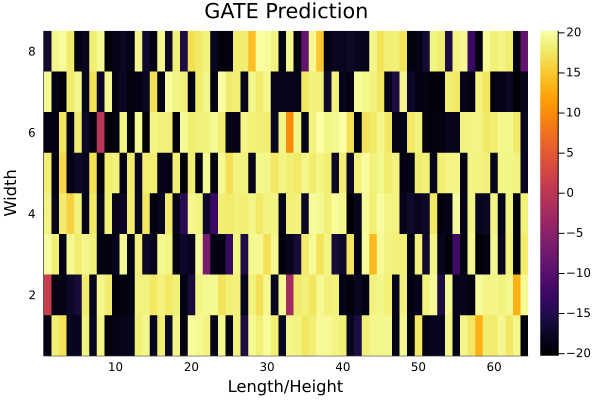

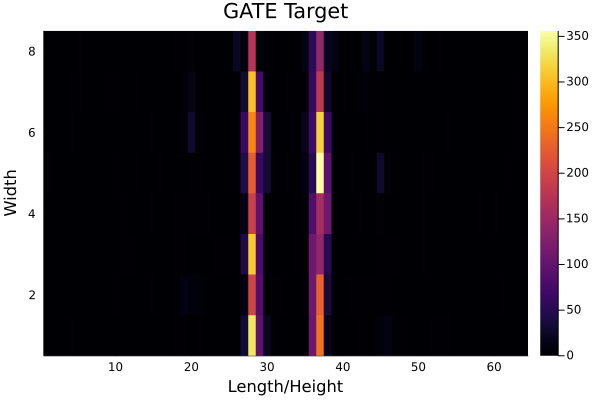

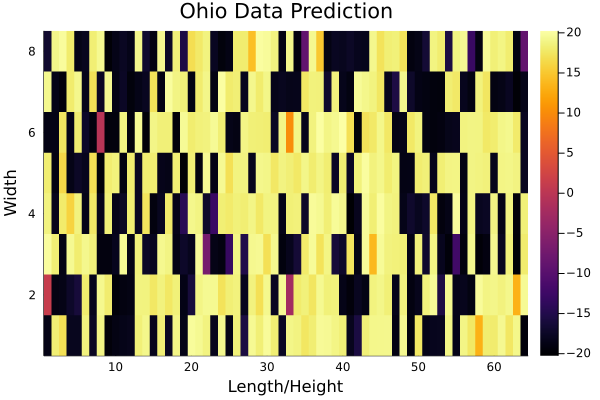

loss(trainingArray, targetArray) = 7711.9546f0
loss(trainingArray, targetArray) = 7709.0127f0
loss(trainingArray, targetArray) = 7707.854f0
loss(trainingArray, targetArray) = 7707.3623f0
loss(trainingArray, targetArray) = 7706.6943f0
loss(trainingArray, targetArray) = 7705.5054f0
loss(trainingArray, targetArray) = 7703.874f0
loss(trainingArray, targetArray) = 7702.064f0
loss(trainingArray, targetArray) = 7700.3213f0
loss(trainingArray, targetArray) = 7698.76f0
loss(trainingArray, targetArray) = 7697.3633f0
loss(trainingArray, targetArray) = 7696.0474f0
loss(trainingArray, targetArray) = 7694.726f0
loss(trainingArray, targetArray) = 7693.3525f0
loss(trainingArray, targetArray) = 7691.922f0
loss(trainingArray, targetArray) = 7690.4565f0
loss(trainingArray, targetArray) = 7688.9805f0
loss(trainingArray, targetArray) = 7687.5044f0
loss(trainingArray, targetArray) = 7686.031f0
loss(trainingArray, targetArray) = 7684.551f0
loss(trainingArray, targetArray) = 7683.0566f0
loss(trainingArray, ta

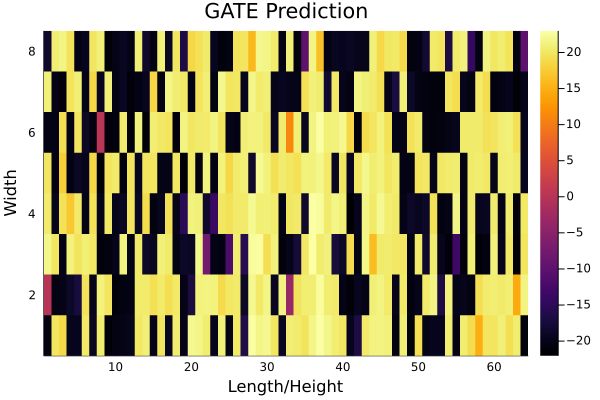

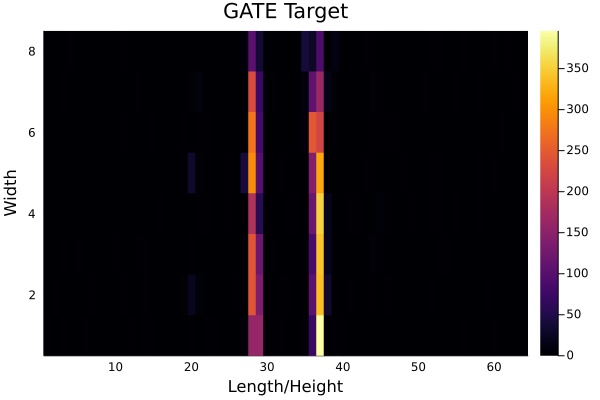

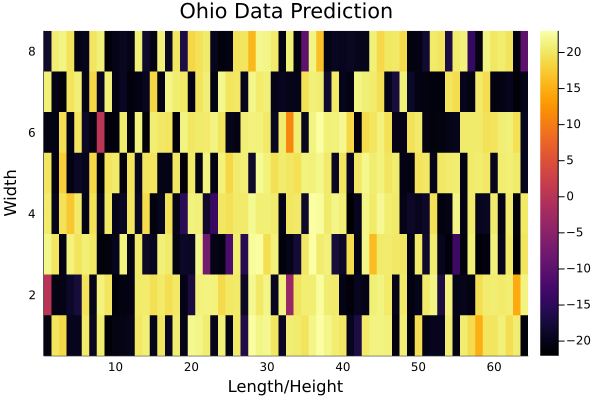

Validation R2: 0.04658366636952804
7loss(trainingArray, targetArray) = 7661.711f0
loss(trainingArray, targetArray) = 7660.013f0
loss(trainingArray, targetArray) = 7658.303f0
loss(trainingArray, targetArray) = 7656.5786f0
loss(trainingArray, targetArray) = 7654.8423f0
loss(trainingArray, targetArray) = 7653.093f0
loss(trainingArray, targetArray) = 7651.33f0
loss(trainingArray, targetArray) = 7649.5547f0
loss(trainingArray, targetArray) = 7647.767f0
loss(trainingArray, targetArray) = 7645.967f0
loss(trainingArray, targetArray) = 7644.1533f0
loss(trainingArray, targetArray) = 7642.3286f0
loss(trainingArray, targetArray) = 7640.4893f0
loss(trainingArray, targetArray) = 7638.64f0
loss(trainingArray, targetArray) = 7636.7773f0
loss(trainingArray, targetArray) = 7634.903f0
loss(trainingArray, targetArray) = 7633.0156f0
loss(trainingArray, targetArray) = 7631.1167f0
loss(trainingArray, targetArray) = 7629.2056f0
loss(trainingArray, targetArray) = 7627.2827f0
loss(trainingArray, targetArray) = 

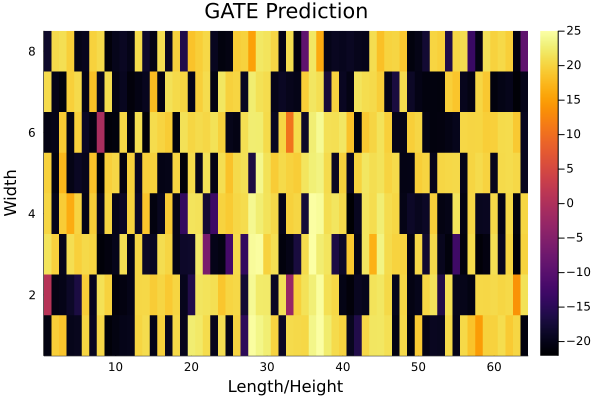

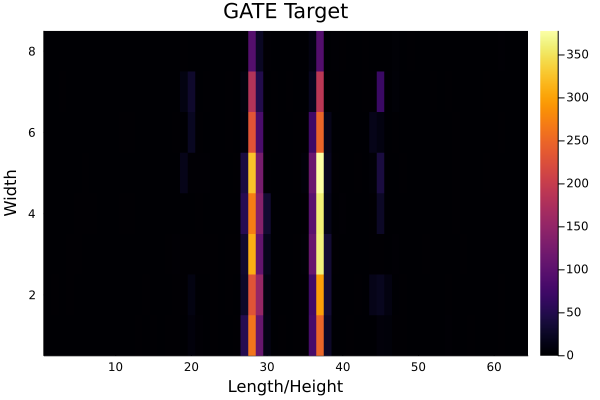

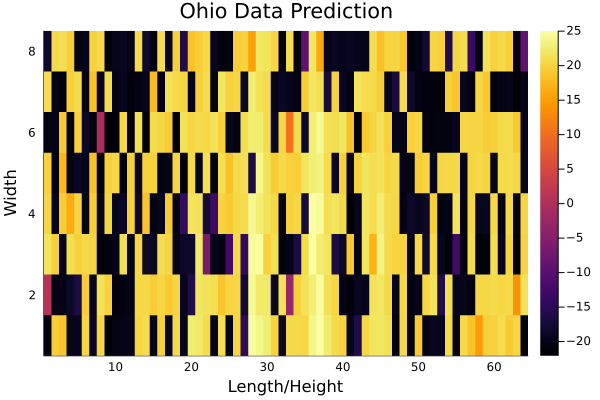

Validation R2: 0.054577575352897645
11

In [41]:
for i = 1:3
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 2))
    CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
    print("Training R2: ", CurrentR2, '\n')
    CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
    print("Validation R2: ", CurrentVR2, '\n')
    plotResults(m)
end

In [42]:
function writeOutput(m)
    readPath = "/home/jupyter-tegan/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    readSize = size(readArray)[1]
    path = "/home/jupyter-tegan/dosimeter/neural_nets/JuliaOutputs/tegan_runs"
    runNumber = lpad(size(readdir(path))[1], 3, "0")
    path = string(path, "/Run", runNumber, "R2-", lpad(Int(round(CurrentVR2, digits=3)*1000),3,"0"))
    mkdir(path)
    mkdir(string(path, "/fullSimulationOutputs"))
    mkdir(string(path, "/fullOhioOutputs"))
    for i = 1:size(validationTargetArray)[2]
        beamSize = filter(x->occursin(string("A000"), x), readdir(readPath))[div(100-1, div(size(validationTargetArray)[2],readSize))+1][1:8]

        writedlm(string(path,"/fullSimulationOutputs/ValidationTarget",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(validationTargetArray[:,i], (8*8,8)), " ")
        writedlm(string(path,"/fullSimulationOutputs/ValidationOutput",lpad(i,3,"0"), "-", beamSize, ".txt"), Int.(round.(reshape(m(validationArray)[:,i], (8*8,8)))), " ")
    end


    readPath = "/home/jupyter-tegan/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    for i = 1:size(inputArray)[4]
        writedlm(string(path,"/fullOhioOutputs/OhioOutput",lpad(i,3,"0"),".txt"), Int.(round.(reshape(m(inputArray)[:,i], (8*8,8)))), " ")
    end
end

writeOutput (generic function with 1 method)

In [ ]:
writeOutput(m)